In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt

from copy import deepcopy as copy
# np.random.seed(1)

In [2]:
!pip install git+https://github.com/kilean20/pyTorchTemplate.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-h1erakyd
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-h1erakyd
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6602 sha256=fc46525946d78ee5f9d27e18051479a3dd75ea867498577cdfd2d4aa0b31a48b
  Stored in directory: /tmp/pip-ephem-wheel-cache-8v66fy5k/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate


In [3]:
!pip install git+https://github.com/kilean20/pyTorchTemplate.git --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/kilean20/pyTorchTemplate.git to /tmp/pip-req-build-lx1p2ifd
  Running command git clone -q https://github.com/kilean20/pyTorchTemplate.git /tmp/pip-req-build-lx1p2ifd
  Created wheel for pyTorchTemplate: filename=pyTorchTemplate-0.0.1-py3-none-any.whl size=6602 sha256=1a665d0dfdf9739de3de54fa7aa76b64ff29d296cc1ff07be01817160d22997e
  Stored in directory: /tmp/pip-ephem-wheel-cache-brldgk1j/wheels/15/b3/6d/10ca0e96789eddf8cbd29d87914215e75608e6930926678261
Successfully built pyTorchTemplate
  Attempting uninstall: pyTorchTemplate
    Found existing installation: pyTorchTemplate 0.0.1
    Uninstalling pyTorchTemplate-0.0.1:
      Successfully uninstalled pyTorchTemplate-0.0.1


In [4]:
import torch
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pyTorchTemplate as ptt

$$
\begin{eqnarray}
\boldsymbol{R} &=& |\boldsymbol{x}| \\
{f} &=& \frac{\sin(4\pi \boldsymbol{R})}{4\pi\boldsymbol{R}}
\end{eqnarray}
$$

In [5]:
ndim = 12
nSample = 2048
p = 8

In [6]:
def f(x):
    """The function to predict."""
    
    R = np.sqrt(np.sum(x**2,axis=1)) + 0.0001
    return np.sin(4*np.pi*R)/(4*np.pi*R)

# Prepare data

In [7]:
x_train = ((np.random.rand(nSample,ndim)-0.5)*2).astype(np.float32)
y_train = f(x_train).reshape(-1,1).astype(np.float32)

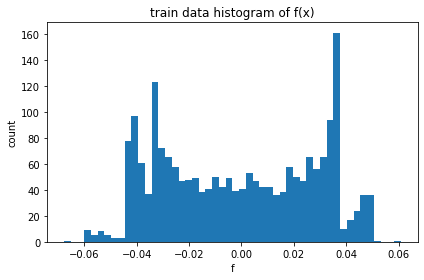

In [8]:
plt.hist(y_train,bins=50);
plt.xlabel('f')
plt.ylabel('count')
plt.title('train data histogram of f(x)')
plt.tight_layout()
plt.savefig('train_data_histo_'+str(ndim)+'D_'+str(nSample)+'sample.png',dpi=180)

In [9]:
x_test = ((np.random.rand(65536,ndim)-0.5)*2).astype(np.float32)
y_test = f(x_test).reshape(-1,1).astype(np.float32)

In [10]:
x_onAxis = np.zeros([256,ndim]).astype(np.float32)
x_onAxis[:,0] = np.linspace(-1, 1, 256)
y_onAxis = f(x_onAxis).reshape(-1,1).astype(np.float32)

In [11]:
train_data_loader = torch.utils.data.DataLoader(list(zip(x_train,y_train)),batch_size=128)
test_data_loader = torch.utils.data.DataLoader(list(zip(x_test,y_test)),batch_size=128)

### GP w/o dim-reduction

In [12]:
kernel = C(0.2, (2e-2, 1e1)) * RBF(1, (2e-2, 1e1))
gpNaive = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [13]:
gpNaive.score(x_train, y_train), gpNaive.score(x_test, y_test)

(-0.0008521033640711551, -0.00010352301880245385)

In [14]:
gpNaive.fit(x_train, y_train)
gpNaive.kernel_

0.141**2 * RBF(length_scale=1.28)

In [15]:
gpNaive.score(x_train, y_train), gpNaive.score(x_test, y_test)   #(0.9999999999999998, 0.2938582961152787)

(0.999999999999981, -1.4292779906019075)

In [16]:
y_onAxis_GPnaive, sigma_GPnaive = gpNaive.predict(x_onAxis, return_std=True)
y_onAxis_GPnaive = y_onAxis_GPnaive.reshape(-1)

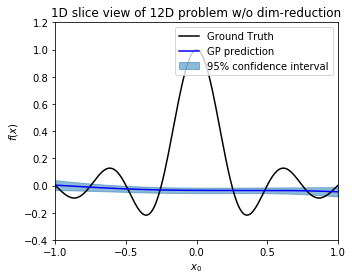

In [17]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GPnaive, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GPnaive- 1.96 * sigma_GPnaive,
                y_onAxis_GPnaive+ 1.96 * sigma_GPnaive, 
                label='95% confidence interval', color='C0', alpha=.5, )
# plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w/o dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_woDimReduct_'+str(ndim)+'D.png',dpi=180)

# with DimReduction

### AutoEncoderLike NN

In [18]:
def test(model,criterion,test_data_loader):
  model.eval()
  loss = 0 
  for x, y in test_data_loader:
    x = x.to(device)
    y_pred = model(x)
    loss += criterion(y_pred, y.to(device)).item()
  return loss/len(test_data_loader)

### 4D source

In [19]:
nsource = 4

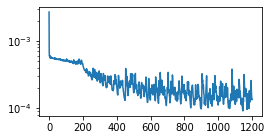

In [21]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN_autoEncoder([ndim,32,32,nsource],[nsource,16,16,1], torch.nn.CELU(inplace=True), residual=True, identity_block_every_layer=True)
  mode,hist = ptt.train_supervised(model,1.0e-2,200,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 1e-2:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,400,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 2e-4:
    continue  
  mode,hist = ptt.train_supervised(model,2.0e-3,600,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 3e-6:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,800,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
#                                 optim_args = {'weight_decay':0.2},
                                # data_loader,
                                old_hist = hist,
                                criterion=ptt.MPELoss(p=p),
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

4.159365312261798e-05


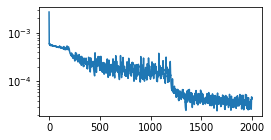

In [22]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
print(newloss)

In [23]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[-0.02673663],
       [-0.03921007],
       [ 0.03575707],
       [-0.02789691],
       [ 0.0242639 ],
       [ 0.02947409],
       [-0.03914564],
       [ 0.04476586],
       [ 0.04417496],
       [ 0.02205328]], dtype=float32)

In [24]:
f(x_train[:10,:])

array([-0.02858959, -0.04246758,  0.03531761, -0.02965405,  0.02321026,
        0.02978526, -0.0423779 ,  0.04572124,  0.04498084,  0.02183215],
      dtype=float32)

##### source from AutoEncoderLike BottleNeck

In [25]:
s_train = model.get_latent_variable(torch.Tensor(x_train)).detach().numpy()

[-2.946931] [8.640887]
[-2.946931, -1.5961797] [8.640887, 13.784833]
[-2.946931, -1.5961797, -5.7590055] [8.640887, 13.784833, 8.8400345]
[-2.946931, -1.5961797, -5.7590055, -3.6363819] [8.640887, 13.784833, 8.8400345, 13.253946]


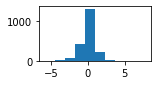

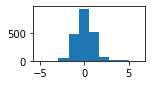

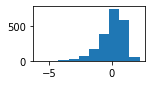

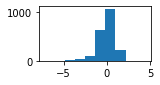

In [26]:
s_mean = []
s_std  = []

for i in range(nsource):
  s_mean.append(s_train[:,i].mean())
  s_std.append(s_train[:,i].std())
  print(s_mean,s_std)
  s_train[:,i] = (s_train[:,i]-s_mean[i])/s_std[i]
  plt.figure(figsize=(2,1))
  plt.hist(s_train[:,i]);

In [27]:
s_test = model.get_latent_variable(torch.Tensor(x_test)).detach().numpy()
for i in range(nsource):
  s_test[:,i] = (s_test[:,i]-s_mean[i])/s_std[i]

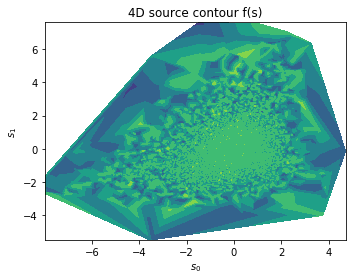

In [28]:
plt.figure(figsize=(5,4))
plt.tricontourf(s_test[:,0],s_test[:,1],y_test.reshape(-1))

plt.title(str(nsource)+'D source contour f(s)')
plt.xlabel(r'$s_0$')
plt.ylabel(r'$s_1$')
plt.tight_layout()
plt.savefig('4Dto2D_source_contour.png',dpi=180)

In [29]:
s_onAxis = model.get_latent_variable(torch.Tensor(x_onAxis)).detach().numpy()
for i in range(nsource):
  s_onAxis[:,i] = (s_onAxis[:,i]-s_mean[i])/s_std[i]

##### GP on source

In [30]:
kernel = C(0.2, (1e-2, 1e1)) * RBF(1, (1e-2, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.1)

In [31]:
gp.score(s_train, y_train), gp.score(s_test, y_test)

(-0.0008521033640711551, -0.00010352301880245385)

In [32]:
gp.fit(s_train, y_train)
gp.kernel_

0.1**2 * RBF(length_scale=9.53)

In [33]:
gp.score(s_train, y_train), gp.score(s_test, y_test)   

(0.7638103920427146, -0.3507433728230278)

##### on axis

In [34]:
y_onAxis_GP, sigma_GP = gp.predict(s_onAxis, return_std=True)
y_onAxis_GP = y_onAxis_GP.reshape(-1)
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

In [35]:
y_onAxis_NN.shape

(256, 1)

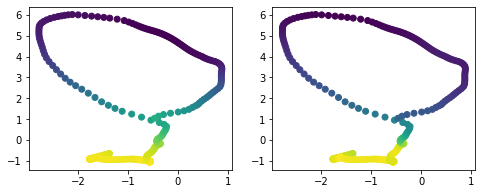

In [36]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_GP)
plt.subplot(1,2,2)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_NN[:,0])

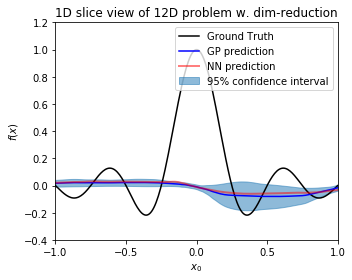

In [37]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GP, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GP- 1.96 * sigma_GP,
                y_onAxis_GP+ 1.96 * sigma_GP, 
                label='95% confidence interval', color='C0', alpha=.5, )
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w. dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_wDimReduct_'+str(ndim)+'D_'+str(nsource)+'source.png',dpi=180)

In [38]:
ptt.count_parameters(model)

15789

### 3D source

In [39]:
nsource = 3

In [40]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN_autoEncoder([ndim,32,32,nsource],[nsource,16,16,1], torch.nn.CELU(inplace=True), residual=True, identity_block_every_layer=True)
  mode,hist = ptt.train_supervised(model,1.0e-2,200,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 1e-2:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,400,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 2e-4:
    continue  
  mode,hist = ptt.train_supervised(model,2.0e-3,600,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 3e-6:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,800,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
#                                 optim_args = {'weight_decay':0.2},
                                # data_loader,
                                old_hist = hist,
                                criterion=ptt.MPELoss(p=p),
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

2.8354019377729855e-05


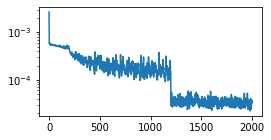

In [41]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])
print(newloss)

In [42]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[-0.02854246],
       [-0.0411815 ],
       [ 0.03548585],
       [-0.02775845],
       [ 0.02368272],
       [ 0.02871934],
       [-0.04118124],
       [ 0.04442731],
       [ 0.04452028],
       [ 0.02100718]], dtype=float32)

In [43]:
f(x_train[:10,:])

array([-0.02858959, -0.04246758,  0.03531761, -0.02965405,  0.02321026,
        0.02978526, -0.0423779 ,  0.04572124,  0.04498084,  0.02183215],
      dtype=float32)

##### source from AutoEncoderLike BottleNeck

In [44]:
s_train = model.get_latent_variable(torch.Tensor(x_train)).detach().numpy()

[-2.9035857] [8.880074]
[-2.9035857, -1.6124] [8.880074, 14.08218]
[-2.9035857, -1.6124, -5.592409] [8.880074, 14.08218, 9.037177]


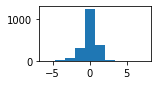

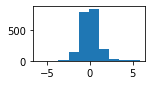

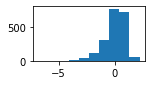

In [45]:
s_mean = []
s_std  = []

for i in range(nsource):
  s_mean.append(s_train[:,i].mean())
  s_std.append(s_train[:,i].std())
  print(s_mean,s_std)
  s_train[:,i] = (s_train[:,i]-s_mean[i])/s_std[i]
  plt.figure(figsize=(2,1))
  plt.hist(s_train[:,i]);

In [46]:
s_test = model.get_latent_variable(torch.Tensor(x_test)).detach().numpy()
for i in range(nsource):
  s_test[:,i] = (s_test[:,i]-s_mean[i])/s_std[i]

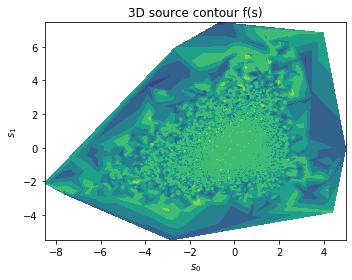

In [47]:
plt.figure(figsize=(5,4))
plt.tricontourf(s_test[:,0],s_test[:,1],y_test.reshape(-1))

plt.title(str(nsource)+'D source contour f(s)')
plt.xlabel(r'$s_0$')
plt.ylabel(r'$s_1$')
plt.tight_layout()
plt.savefig('4Dto2D_source_contour.png',dpi=180)

In [48]:
s_onAxis = model.get_latent_variable(torch.Tensor(x_onAxis)).detach().numpy()
for i in range(nsource):
  s_onAxis[:,i] = (s_onAxis[:,i]-s_mean[i])/s_std[i]

##### GP on source

In [49]:
kernel = C(0.2, (1e-2, 1e1)) * RBF(1, (1e-2, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.1)

In [50]:
gp.score(s_train, y_train), gp.score(s_test, y_test)

(-0.0008521033640711551, -0.00010352301880245385)

In [51]:
gp.fit(s_train, y_train)
gp.kernel_

0.1**2 * RBF(length_scale=10)

In [52]:
gp.score(s_train, y_train), gp.score(s_test, y_test)   

(0.8742485814249776, -0.5973684559599013)

##### on axis

In [53]:
y_onAxis_GP, sigma_GP = gp.predict(s_onAxis, return_std=True)
y_onAxis_GP = y_onAxis_GP.reshape(-1)
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

In [54]:
y_onAxis_NN.shape

(256, 1)

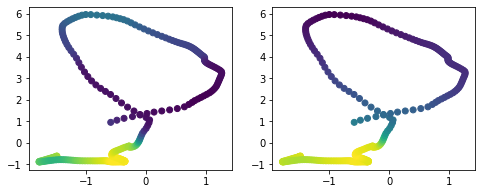

In [55]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_GP)
plt.subplot(1,2,2)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_NN[:,0])

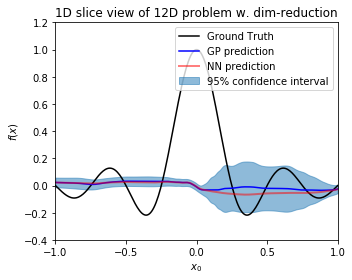

In [56]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GP, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GP- 1.96 * sigma_GP,
                y_onAxis_GP+ 1.96 * sigma_GP, 
                label='95% confidence interval', color='C0', alpha=.5, )
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w. dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_wDimReduct_'+str(ndim)+'D_'+str(nsource)+'source.png',dpi=180)

In [57]:
ptt.count_parameters(model)

15789

### 2D source

In [58]:
nsource = 2

In [59]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN_autoEncoder([ndim,32,32,nsource],[nsource,16,16,1], torch.nn.CELU(inplace=True), residual=True, identity_block_every_layer=True)
  mode,hist = ptt.train_supervised(model,1.0e-2,200,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 1e-2:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,400,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 2e-4:
    continue  
  mode,hist = ptt.train_supervised(model,2.0e-3,600,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 3e-6:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,800,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
#                                 optim_args = {'weight_decay':0.2},
                                # data_loader,
                                old_hist = hist,
                                criterion=ptt.MPELoss(p=p),
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

3.687274340791191e-05


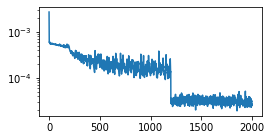

In [60]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])
print(newloss)

In [61]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[-0.02750011],
       [-0.04084405],
       [ 0.03370432],
       [-0.03037477],
       [ 0.02215762],
       [ 0.02790692],
       [-0.04164092],
       [ 0.0439841 ],
       [ 0.04302785],
       [ 0.02058261]], dtype=float32)

In [62]:
f(x_train[:10,:])

array([-0.02858959, -0.04246758,  0.03531761, -0.02965405,  0.02321026,
        0.02978526, -0.0423779 ,  0.04572124,  0.04498084,  0.02183215],
      dtype=float32)

##### source from AutoEncoderLike BottleNeck

In [63]:
s_train = model.get_latent_variable(torch.Tensor(x_train)).detach().numpy()

[-3.2344928] [9.278825]
[-3.2344928, -1.7840537] [9.278825, 14.218466]


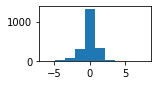

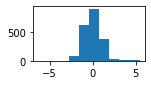

In [64]:
s_mean = []
s_std  = []

for i in range(nsource):
  s_mean.append(s_train[:,i].mean())
  s_std.append(s_train[:,i].std())
  print(s_mean,s_std)
  s_train[:,i] = (s_train[:,i]-s_mean[i])/s_std[i]
  plt.figure(figsize=(2,1))
  plt.hist(s_train[:,i]);

In [65]:
s_test = model.get_latent_variable(torch.Tensor(x_test)).detach().numpy()
for i in range(nsource):
  s_test[:,i] = (s_test[:,i]-s_mean[i])/s_std[i]

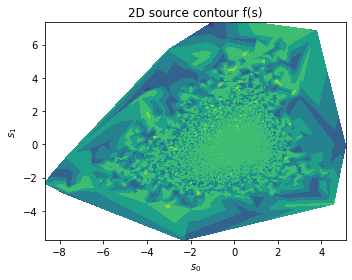

In [66]:
plt.figure(figsize=(5,4))
plt.tricontourf(s_test[:,0],s_test[:,1],y_test.reshape(-1))

plt.title(str(nsource)+'D source contour f(s)')
plt.xlabel(r'$s_0$')
plt.ylabel(r'$s_1$')
plt.tight_layout()
plt.savefig('4Dto2D_source_contour.png',dpi=180)

In [67]:
s_onAxis = model.get_latent_variable(torch.Tensor(x_onAxis)).detach().numpy()
for i in range(nsource):
  s_onAxis[:,i] = (s_onAxis[:,i]-s_mean[i])/s_std[i]

##### GP on source

In [68]:
kernel = C(0.2, (1e-2, 1e1)) * RBF(1, (1e-2, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.1)

In [69]:
gp.score(s_train, y_train), gp.score(s_test, y_test)

(-0.0008521033640711551, -0.00010352301880245385)

In [70]:
gp.fit(s_train, y_train)
gp.kernel_

0.1**2 * RBF(length_scale=10)

In [71]:
gp.score(s_train, y_train), gp.score(s_test, y_test)   

(0.8768265586171784, -0.5874202828556647)

##### on axis

In [72]:
y_onAxis_GP, sigma_GP = gp.predict(s_onAxis, return_std=True)
y_onAxis_GP = y_onAxis_GP.reshape(-1)
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

In [73]:
y_onAxis_NN.shape

(256, 1)

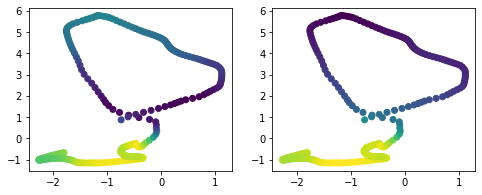

In [74]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_GP)
plt.subplot(1,2,2)
plt.scatter(s_onAxis[:,0],s_onAxis[:,1],c=y_onAxis_NN[:,0])

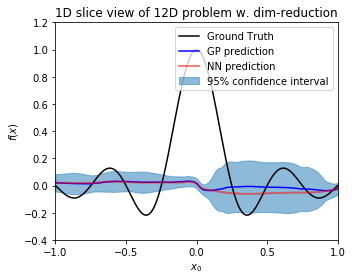

In [75]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GP, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GP- 1.96 * sigma_GP,
                y_onAxis_GP+ 1.96 * sigma_GP, 
                label='95% confidence interval', color='C0', alpha=.5, )
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w. dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_wDimReduct_'+str(ndim)+'D_'+str(nsource)+'source.png',dpi=180)

In [76]:
ptt.count_parameters(model)

15789

### 1D source

In [77]:
nsource = 1

In [78]:
old_best_loss = 1
for i in range(10):
  model = ptt.resFCNN_autoEncoder([ndim,32,32,nsource],[nsource,16,16,1], torch.nn.CELU(inplace=True), residual=True, identity_block_every_layer=True)
  mode,hist = ptt.train_supervised(model,1.0e-2,200,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 1e-2:
    continue
  mode,hist = ptt.train_supervised(model,2.0e-3,400,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  if newloss > 1e-4:
    continue  
  mode,hist = ptt.train_supervised(model,2.0e-3,600,
                                  train_data_loader,
                                  optimizer=torch.optim.Adam,
#                                   optim_args = {'weight_decay':0.2},
                                  criterion=ptt.MPELoss(p=p),
                                  old_hist = hist,
                                  old_best_loss = old_best_loss,
                                  dispHead = 0, dispTail = 0)
  newloss = test(model,ptt.MPELoss(p=p),train_data_loader)
  
  if newloss < old_best_loss:
    old_best_loss = newloss
    final_model = copy(model)
    final_hist  = copy(hist)
    
  if newloss < 1e-6:
    break
    
  plt.figure(figsize=(4,2))
  plt.semilogy(hist['train_loss'])
  plt.semilogy(hist['test_loss'])

model = final_model
hist = final_hist
mode,hist = ptt.train_supervised(model,5.0e-4,800,
                                train_data_loader,
                                optimizer=torch.optim.Adam,
#                                 optim_args = {'weight_decay':0.2},
                                # data_loader,
                                old_hist = hist,
                                criterion=ptt.MPELoss(p=p),
                                old_best_loss = newloss,
                                dispHead = 0, dispTail = 0)
newloss = test(model,ptt.MPELoss(p=p),train_data_loader)


model = model.cpu()
model.eval();

2.465026159370609e-05


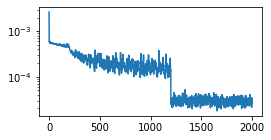

In [79]:
plt.figure(figsize=(4,2))
plt.semilogy(hist['train_loss'])
plt.semilogy(hist['test_loss'])
print(newloss)

In [80]:
model(torch.Tensor(x_train[:10,:])).detach().numpy()

array([[-0.02874384],
       [-0.04158698],
       [ 0.03423403],
       [-0.02859466],
       [ 0.02170909],
       [ 0.0295857 ],
       [-0.04161062],
       [ 0.04375323],
       [ 0.04415656],
       [ 0.0201398 ]], dtype=float32)

In [81]:
f(x_train[:10,:])

array([-0.02858959, -0.04246758,  0.03531761, -0.02965405,  0.02321026,
        0.02978526, -0.0423779 ,  0.04572124,  0.04498084,  0.02183215],
      dtype=float32)

##### source from AutoEncoderLike BottleNeck

In [82]:
s_train = model.get_latent_variable(torch.Tensor(x_train)).detach().numpy()

[-3.131072] [9.660722]


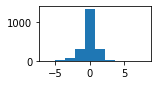

In [83]:
s_mean = []
s_std  = []

for i in range(nsource):
  s_mean.append(s_train[:,i].mean())
  s_std.append(s_train[:,i].std())
  print(s_mean,s_std)
  s_train[:,i] = (s_train[:,i]-s_mean[i])/s_std[i]
  plt.figure(figsize=(2,1))
  plt.hist(s_train[:,i]);

In [84]:
s_test = model.get_latent_variable(torch.Tensor(x_test)).detach().numpy()
for i in range(nsource):
  s_test[:,i] = (s_test[:,i]-s_mean[i])/s_std[i]

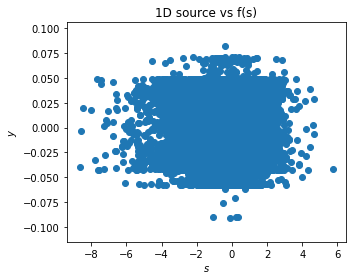

In [85]:
plt.figure(figsize=(5,4))
plt.scatter(s_test[:,0],y_test.reshape(-1))

plt.title(str(nsource)+'D source vs f(s)')
plt.xlabel(r'$s$')
plt.ylabel(r'$y$')
plt.tight_layout()
plt.savefig('4Dto1D_source_contour.png',dpi=180)

In [86]:
s_onAxis = model.get_latent_variable(torch.Tensor(x_onAxis)).detach().numpy()
for i in range(nsource):
  s_onAxis[:,i] = (s_onAxis[:,i]-s_mean[i])/s_std[i]

##### GP on source

In [87]:
kernel = C(0.2, (1e-2, 1e1)) * RBF(1, (1e-2, 1e1))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.1)

In [88]:
gp.score(s_train, y_train), gp.score(s_test, y_test)

(-0.0008521033640711551, -0.00010352301880245385)

In [89]:
gp.fit(s_train, y_train)
gp.kernel_

0.1**2 * RBF(length_scale=10)

In [90]:
gp.score(s_train, y_train), gp.score(s_test, y_test)   

(0.9310654483172163, -0.5784877600597689)

##### on axis

In [91]:
y_onAxis_GP, sigma_GP = gp.predict(s_onAxis, return_std=True)
y_onAxis_GP = y_onAxis_GP.reshape(-1)
y_onAxis_NN = model(torch.Tensor(x_onAxis)).detach().numpy() 

In [92]:
y_onAxis_NN.shape

(256, 1)

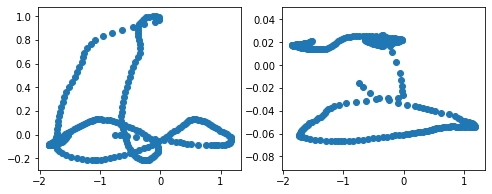

In [93]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.scatter(s_onAxis[:,0],y_onAxis)
plt.subplot(1,2,2)
plt.scatter(s_onAxis[:,0],y_onAxis_NN)

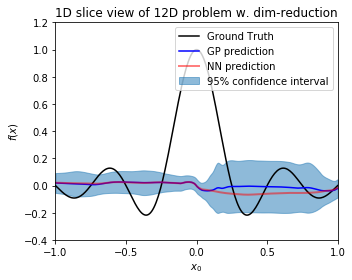

In [94]:
fig = plt.figure(figsize=(5,4))

plt.plot(x_onAxis[:,0],y_onAxis ,'k' , label='Ground Truth')
plt.plot(x_onAxis[:,0],y_onAxis_GP, 'b-', label='GP prediction')
plt.fill_between(x_onAxis[:,0], 
                y_onAxis_GP- 1.96 * sigma_GP,
                y_onAxis_GP+ 1.96 * sigma_GP, 
                label='95% confidence interval', color='C0', alpha=.5, )
plt.plot(x_onAxis[:,0],y_onAxis_NN, 'r-', label='NN prediction',lw=2,alpha=0.5)

plt.title('1D slice view of '+str(ndim)+'D problem w. dim-reduction')
plt.xlabel(r'$x_0$')
plt.ylabel(r'$f(x)$')
plt.legend(loc='upper right')
plt.xlim(-1,1)
plt.ylim(-0.4,1.2)
plt.xticks([-1,-0.5,0,0.5,1])
plt.tight_layout()
plt.savefig('GP_wDimReduct_'+str(ndim)+'D_'+str(nsource)+'source.png',dpi=180)

In [95]:
ptt.count_parameters(model)

15789